## A/B Test Forecast

This forecast is built for SaaS products with free trial periods. It will predict whether or not there will be a statistically significant difference in conversion rate between different groups of an A/B test.

The forecast first gathers historical data from the A/B test and analyzes how the conversion rate is trending for that historical data. Once the predicted conversion rate for the historical data is complete, the assumed conversion rates are applied to each group in the A/B test for future data.

**Users have the ability to select different inputs for future test data, including...**

1. Days the A/B test runs in the future
2. How many entries are added to the A/B test each day
3. Adjustments in conversion rate performance (+/- X%)

**The forecast also includes the following assumptions...**

1. There can be up to 4 different groups in the A/B test
2. Forecast allows up to 6 weeks of historical data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [2]:
# Upload historical data from test
# Conversion dates where chosen at random. This doesn't follow a typical logarithmic curve of a SaaS product!
# May have to change it for logarithmic curves

raw = pd.read_csv('/Users/Matt/Desktop/Programming/Python/AB_TestForecast/test_data.csv', na_values=' ')


In [3]:
# Convert date fields from object to date format

raw['TRIAL_START_DATE'] = pd.to_datetime(raw['TRIAL_START_DATE'])
raw['CONVERT_DATE'] = pd.to_datetime(raw['CONVERT_DATE'])


In [4]:
# Preview data

raw.info()
raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25483 entries, 0 to 25482
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UID               25483 non-null  int64         
 1   GROUP_NAME        25483 non-null  object        
 2   TRIAL_START_DATE  25483 non-null  datetime64[ns]
 3   CONVERT_DATE      6297 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 796.5+ KB


,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE
0,1114728035448,4947a_Control,2013-09-02,2013-09-05
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20
2,1114497359375,4947a_Control,2013-08-14,2013-09-01
3,1114329428592,4947a_Control,2013-07-29,2013-07-31
4,1114539386764,4947a_Control,2013-08-16,NaT


The first variables that need to be created are the first date of the test (test_start) and the latest date of the test (test_latest) aka the most recent day. 

During a live test, these dates will help us determine the historical data up to that point. Later, we'll create conversion rates by days into trial. We want to only include applicable data for the conversion rates. For example...

If we are calculating the conversion rate for day 5 of trial, we want to only include UIDs who have been in trial for at least 5 days.

In [5]:
# Create variable for first and latest dates of the A/B Test

test_start = raw.TRIAL_START_DATE.min()
test_latest = raw.TRIAL_START_DATE.max()


In [6]:
# Calculate difference between the latest day of the test and the day the UID entered the test
# (raw['TRIAL_START_DATE'] - trial_start) results in timedelta, so need to use dt.days to convert to int format

raw['daysInTest'] = (test_latest - raw['TRIAL_START_DATE']).dt.days


In [7]:
print(test_latest)
raw.info()
raw.head()


2013-09-15 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25483 entries, 0 to 25482
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UID               25483 non-null  int64         
 1   GROUP_NAME        25483 non-null  object        
 2   TRIAL_START_DATE  25483 non-null  datetime64[ns]
 3   CONVERT_DATE      6297 non-null   datetime64[ns]
 4   daysInTest        25483 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 995.6+ KB


,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE,daysInTest
0,1114728035448,4947a_Control,2013-09-02,2013-09-05,13
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20,28
2,1114497359375,4947a_Control,2013-08-14,2013-09-01,32
3,1114329428592,4947a_Control,2013-07-29,2013-07-31,48
4,1114539386764,4947a_Control,2013-08-16,NaT,30


In [8]:
# Calculate difference between the conversion date and the sign up date

raw['convertDiff'] = (raw['CONVERT_DATE'] - raw['TRIAL_START_DATE']).dt.days


In [9]:
# Create function to create columns for converting on days 1 - 60
# Conversion on the same day as sign up counts as Convert1

def create_conversion_columns():
    i = 0
    while i <= 59:
        raw['convert'+str(i+1)] = raw['convertDiff'].apply(lambda row: 1 if row <= i else 0)
        i += 1


In [10]:
# run function to add conversion columns

create_conversion_columns()


In [11]:
raw.head(10)

,UID,GROUP_NAME,TRIAL_START_DATE,CONVERT_DATE,daysInTest,convertDiff,convert1,convert2,convert3,convert4,...,convert51,convert52,convert53,convert54,convert55,convert56,convert57,convert58,convert59,convert60
0,1114728035448,4947a_Control,2013-09-02,2013-09-05,13,3.0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
1,1114567510056,4947b_Limit10,2013-08-18,2013-08-20,28,2.0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1114497359375,4947a_Control,2013-08-14,2013-09-01,32,18.0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1114329428592,4947a_Control,2013-07-29,2013-07-31,48,2.0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1114539386764,4947a_Control,2013-08-16,NaT,30,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1114607306925,4947c_Limit100,2013-08-22,NaT,24,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1114692932614,4947b_Limit10,2013-08-29,NaT,17,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1114528516488,4947a_Control,2013-08-15,NaT,31,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1114539386902,4947c_Limit100,2013-08-16,NaT,30,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1114763662847,4947c_Limit100,2013-09-03,NaT,12,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Create Dataframe that will hold the conversion rates by day of trial

conversionRates = pd.DataFrame(index = raw['GROUP_NAME'].unique())
conversionRates


""
4947a_Control
4947b_Limit10
4947c_Limit100


In [15]:
# Create function to calculate conversion rates by day of trial and append to conversionRates dataframe
# Conversion on the same day as sign up counts as Convert1

def calculate_conversion_rates():
    i = 1
    while i <= 60:
        daysInTest = raw.loc[raw['daysInTest'] >= i]
        temp = daysInTest.groupby('GROUP_NAME')['convert'+str(i)].agg(['sum', 'size'])
        conversionRates['convertRateDay'+str(i)] = temp['sum'] / temp['size'] * 100
        i += 1


In [16]:
# run function to calculate conversion rates

calculate_conversion_rates()


In [17]:
# Check conversion rate data

conversionRates


,convertRateDay1,convertRateDay2,convertRateDay3,convertRateDay4,convertRateDay5,convertRateDay6,convertRateDay7,convertRateDay8,convertRateDay9,convertRateDay10,...,convertRateDay51,convertRateDay52,convertRateDay53,convertRateDay54,convertRateDay55,convertRateDay56,convertRateDay57,convertRateDay58,convertRateDay59,convertRateDay60
4947a_Control,0.0,0.0,1.139166,2.409780,3.843893,5.097716,6.541726,7.651497,8.760759,10.215878,...,24.927536,23.369565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4947b_Limit10,0.0,0.0,1.376201,2.467671,3.940653,5.319402,6.774424,8.380884,9.545887,10.768682,...,26.011561,30.726257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4947c_Limit100,0.0,0.0,1.267754,2.583979,3.911665,5.021757,6.416294,7.622526,8.803771,10.225262,...,25.852273,27.011494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# In order to plot the conversion rates on a line graph, the conversionRates dataframe needs to be transposed
conversionRatesTransposed = conversionRates.T


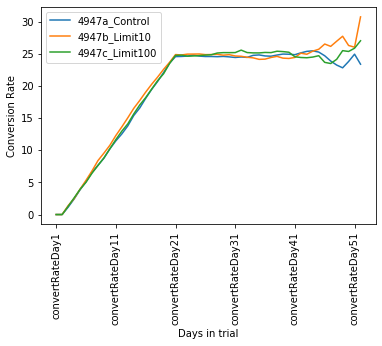

In [19]:
# Plot conversion rates with matplotlib and check result of function

# gca stands for 'get current axis'
ax = plt.gca()

conversionRatesTransposed.plot(kind='line',y='4947a_Control', ax=ax)
conversionRatesTransposed.plot(kind='line',y='4947b_Limit10', ax=ax)
conversionRatesTransposed.plot(kind='line',y='4947c_Limit100', ax=ax)

plt.xlabel('Days in trial')
plt.ylabel('Conversion Rate')
plt.xticks(rotation='vertical')
plt.show()

plt.close()


In [20]:
# Create empty list that will hold the log values for day of trial (1 - 60)

log_values = []


In [21]:
# Create function to calculate natural log values by day of trial and append to log_values empty list
# Conversion on the same day as sign up counts as Convert1

def create_natural_log_values():
    i = 1
    while i <= 60:
        log_values.append(np.log(i))
        i += 1


In [22]:
# run function to calculate natural log values by day of trial

create_natural_log_values()


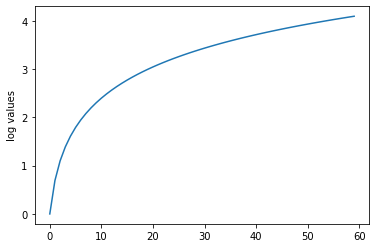

In [33]:
# Plot log values with matplotlib and check result of function

plt.plot(log_values)
plt.ylabel('log values')
plt.show()

plt.close()

# log_values


## MX + B

**Slope**
y2 - y1 / x2 - x1 
conversion rates / logarithmic values

**M**

To get M, pd.Series().diff needs to be used to get the difference between incremental values. 
This will be done for conversion rates as well as the log values. The result will be M.

**B**

To get B, Using the "slope-intercept" form of the line's equation (y = mx + b), you solve for b (which is the y-intercept you're looking for). Substitute the known slope for m, and substitute the known point's coordinates for x and y, respectively, in the slope-intercept equation. That will let you find b


In [56]:
# Calculate the slope for each day of trial (1 - 60)
# https://support.microsoft.com/en-us/office/slope-function-11fb8f97-3117-4813-98aa-61d7e01276b9
# https://stackoverflow.com/questions/55192423/calculate-slope-in-dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html

conversionRatesTransposedDiff = conversionRatesTransposed.diff()


In [53]:
# Need to create dataframe with convertRateDayX as index and log values as column. 

logValuesTransposedDiff = pd.DataFrame(pd.Series(log_values).diff(), columns = ['logValueDiff'])

logValuesTransposedDiff.set_index(conversionRatesTransposedDiff.index, inplace=True)

logValuesTransposedDiff


,logValueDiff
convertRateDay1,NaN
convertRateDay2,0.693147
convertRateDay3,0.405465
convertRateDay4,0.287682
convertRateDay5,0.223144
convertRateDay6,0.182322
convertRateDay7,0.154151
convertRateDay8,0.133531
convertRateDay9,0.117783
convertRateDay10,0.105361


In [55]:

# Then Merge with conversionRates Transposed
test = conversionRatesTransposedDiff.merge(logValuesTransposedDiff, left_index=True, right_index=True)

test

,4947a_Control,4947b_Limit10,4947c_Limit100,logValueDiff
convertRateDay1,NaN,NaN,NaN,NaN
convertRateDay2,0.000000,0.000000,0.000000,0.693147
convertRateDay3,1.139166,1.376201,1.267754,0.405465
convertRateDay4,1.270614,1.091470,1.316225,0.287682
convertRateDay5,1.434113,1.472982,1.327685,0.223144
convertRateDay6,1.253823,1.378749,1.110093,0.182322
convertRateDay7,1.444010,1.455022,1.394537,0.154151
convertRateDay8,1.109772,1.606461,1.206232,0.133531
convertRateDay9,1.109262,1.165002,1.181245,0.117783
convertRateDay10,1.455119,1.222795,1.421491,0.105361
